<a href="https://colab.research.google.com/github/LucianoPer/VPC2/blob/main/5_Residual_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Entrenar redes muy profundas presenta dificultades:
 * Una son los gradientes que tienden a cero o explotan (vanishing y exploding gradients). 

Una de las soluciones para esto es ***Batch Normalization***
 * La otra es la degradación de la performance en el training set.

Una de las técnicas para resolverlo son las ***redes residuales***.



### **Batch Normalization**

Consiste en normalizar la entrada para que valor medio sea cero y la varianza sea unitaria dentro de cada batch, luego se le agregan dos parametros entrenables (gama y beta) que generan un cambio de la media y la desviacion.   

### **Redes Residuales**


En las ResNets las 'skip connections' o 'shortcuts' o 'residual connections' permiten 'saltar capas' y realizar una copia o realimentacion de esta en la capa a la cual saltamos, donde se suma a la activacion de esa capa. AL Agregar un bloque adicional con una conexión residual se imita la función identidad, por lo tanto agregar bloques residuales agrega poco riesgo de degradar la performance en el set de entrenamiento.
    
- El bloque con tamaño de entrada = tamaño de salida se llama bloque identidad (identity block).
- El bloque con entrada != tamaño de salida se llama bloque convolucional (convolutional block).
    


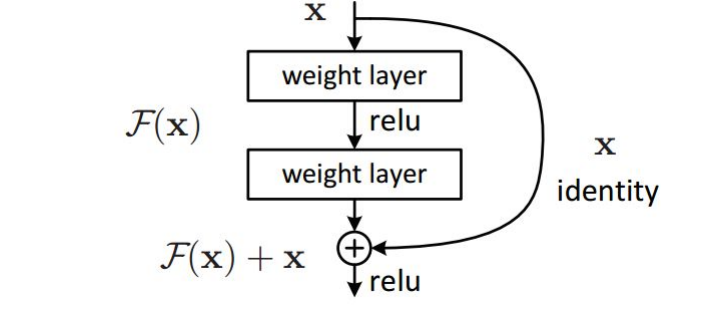

### Bloque identidad

El bloque identidad es un bloque estándar utilizado en ResNets, y corresponde al caso en que la activación de entrada (por ej. $a^{[l]}$)  tiene la misma dimensión a la activación de salida ($a^{[l+2]}$). 

**ResNet-24**

La skip conection en las lineas punteadas se utilizan con convoluciones para que coincidan las dimensiones de las capas en esos puntos, es decir las capas anteriores tienen menor cantidad de dimensiones que las siguientes, por lo tanto no podemos sumarlos si son de diferentes dimension. 

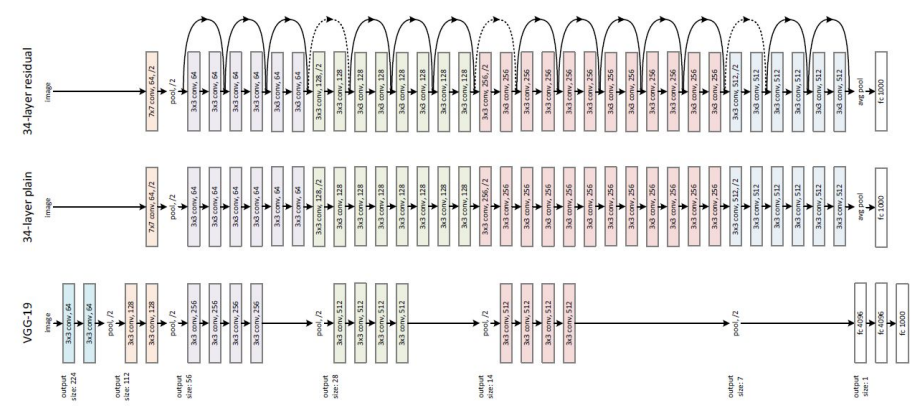

### **Versiones de ResNet**

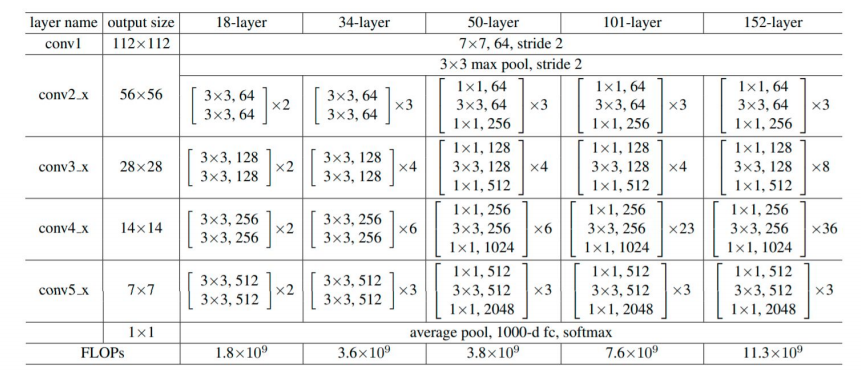

Para ejemplificar lo que ocurre con las redes profundas se entrena una red tradicional a la que se le agregan capas para aumentar la profundidad y luego observamos como se produce una degradacion proporcional a la profundidad. Luego comparamos con una Res-Net realimentando cada dos capas la entrada.

### Creemos una red y vayamos aumentando la cantidad de capas

El objetivo es crear redes con una cantidad incremental de capas. Vamos a fitear los modelos a las función sen(x). Cada ejemplo del dataset toma es un array con 10 números generados con distribución normal. La función a aprender es la que aplica sen(x) elemento a elemento.

In [ ]:
import math
import tensorflow as tf

def sin():
    while True:
        x = tf.random.normal((32, 10), math.pi, 1.5)
        y = tf.math.sin(x)
        yield (x, y)


dts = tf.data.Dataset.from_generator(sin, (tf.float32, tf.float32), ((32, 10), (32, 10)))

La funcion genera batches de 32 ejemplos con 10 valores a los cuales le calcula el seno.  

Generamos datasets de 32 ejemplos:

In [ ]:
x,y = list(dts.take(1).as_numpy_iterator())[0]

In [ ]:
print(x[0])
print(y[0])
# Comparamos que la funcion este calculando el valor correcto
print(tf.math.sin(x[0]))

[1.9451557 2.4937491 2.1342318 2.4735115 5.29161   3.7293644 3.1486783
 4.190458  3.8477292 0.8870218]
[ 0.9307421   0.6034683   0.84542525  0.61948085 -0.83688945 -0.5545081
 -0.00708559 -0.866858   -0.648899    0.7751938 ]
tf.Tensor(
[ 0.9307421   0.6034683   0.84542525  0.61948085 -0.83688945 -0.5545081
 -0.00708559 -0.866858   -0.648899    0.77519375], shape=(10,), dtype=float32)


La funcion crea modelos donde aumenta progresivamente la profundidad de las capas. Se observa como el modelo mejora hasta cierto punto y luego sufre una degradacion.

In [ ]:
n_capas = 25

import numpy as np
def build_model(n):
    x = inputs = tf.keras.Input((10, ))
    # agregamos n capas de 10 unidades ocultas
    for _ in range(n):
        x = tf.keras.layers.Dense(10, activation="relu")(x)
    x = tf.keras.layers.Dense(10)(x) # capa densa final
    model = tf.keras.Model(inputs, x)
    model.compile("adam", "mse")
    return model

print("Red Neuronal 'normal'")
loss_history = []
for t in range(1, n_capas + 1):
    plain = build_model(t)
    print(plain.summary())
    hist = plain.fit(dts, steps_per_epoch=20, epochs=20*t, verbose=0)
    loss_history.append(hist.history["loss"][-1])
    print(hist.history["loss"][-1])

Red Neuronal 'normal'
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________
None
0.5390228629112244
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

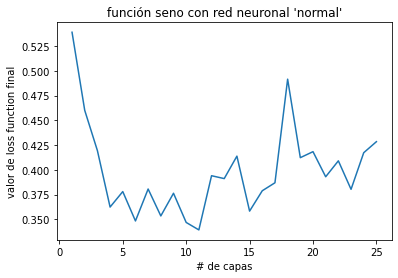

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, n_capas + 1), loss_history)
plt.title("función seno con red neuronal 'normal'")
plt.xlabel("# de capas")
plt.ylabel("valor de loss function final")
plt.show()

Ahora vamos a crear una Red Residual para evitar que se genere la degradacion al aumentar la profundidad de la Red. Cada dos capas densas se suma la entrada. Esto no agrega ningun parametro nuevo a entrenar. 

In [ ]:
def resblock(inputs):
  x = tf.keras.layers.Dense(10, activation="relu")(inputs)
  x = tf.keras.layers.Dense(10)(x)
  # Le sumamos la entrada a la salida de las dos capas densas 
  x = x + inputs # 'skip' en la conexión
  # Luego de sumar se aplica la no linealidad a la suma
  x = tf.keras.layers.Activation("relu")(x)
  return x

def build_resnet_model(n): # hacemos una resnet con n capas
  x = inputs = tf.keras.Input((10, ))
  x = tf.keras.layers.Dense(10, activation='relu')(x)

    # cada bloque residual tiene dos capas
  for _ in range((n-2)//2):
    x = resblock(x)

  x = tf.keras.layers.Dense(10)(x)

  model = tf.keras.Model(inputs, x)
  model.compile("adam", "mse")
  return model

resnet_loss_history = []
print("Red Neuronal residual")
for t in range(2, n_capas + 1, 2):
    resnet = build_resnet_model(t)
    print(resnet.summary())
    hist = resnet.fit(dts, steps_per_epoch=20, epochs=20*t, verbose=0)
    resnet_loss_history.append(hist.history["loss"][-1])
    print(resnet_loss_history[-1])

Red Neuronal residual
Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
dense_350 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_351 (Dense)            (None, 10)                110       
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________
None
0.5353816151618958
Model: "functional_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 10)]         0                                            
___________________

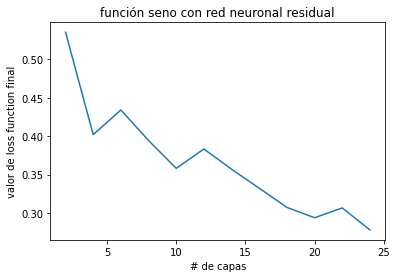

In [ ]:
plt.plot(range(2, n_capas+1, 2), resnet_loss_history)
plt.title("función seno con red neuronal residual")
plt.xlabel("# de capas")
plt.ylabel("valor de loss function final")
plt.show()


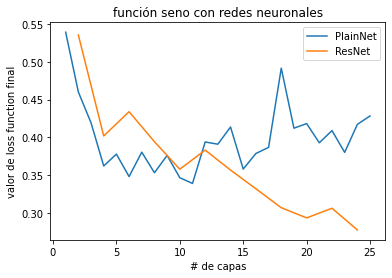

In [ ]:
plt.plot(range(1, n_capas+1), loss_history, label="PlainNet")
plt.plot(range(2, n_capas+1, 2), resnet_loss_history, label="ResNet")
plt.title("función seno con redes neuronales")
plt.xlabel("# de capas")
plt.ylabel("valor de loss function final")
plt.legend()
plt.show()

**Podemos ver que la red Residual a performado mejor que la red clasica, logrando valores de "loss" muy bajos y evitando la degradacion que se produce al aumentar la profundidad de la red.**